# ベイズ最適化
See https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html


In [1]:
# ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

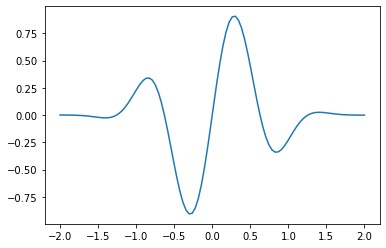

In [2]:
# ターゲット関数
def f(x):
    return np.sin(5 * x) * (1 - np.tanh(x ** 2))

x_grid = np.linspace(-2, 2, 100)
plt.plot(x_grid, f(x_grid))
plt.show()

In [3]:
n_init = 3  # 獲得関数の評価前に初期値として評価する点の数
n_eval = 10  # 獲得関数の最大値として評価する点の数
# acq_func = 'LCB'
acq_func = 'EI'

from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
kernel = ConstantKernel(constant_value=0.01,
                        constant_value_bounds=(0.01, 1000.0))
kernel *= Matern(length_scale=1.0,
                 length_scale_bounds=[(0.01, 100)],
                 nu=2.5)
base_estimator = GaussianProcessRegressor(kernel=kernel,
                                          normalize_y=True,
                                          noise=1e-10,
                                          n_restarts_optimizer=2)

from skopt import gp_minimize
res = gp_minimize(func=lambda x: -f(x[0]),  # maximizeにするため正負反転させる
                  dimensions=[(-2.0, +2.0)],  # -2 < x < +2 の範囲を探索
                  base_estimator=base_estimator,
                  n_calls=n_init + n_eval,
                  n_initial_points=n_init,
                  acq_func=acq_func,
                  noise=1e-10
                  )

## Plot

In [4]:

x_grid = np.linspace(-2, 2, 100)
x_grid_trans = res.space.transform(x_grid[:, np.newaxis])

fig, ax = plt.subplots()

def _animate(idx):
    ax.clear()

    mean, std = res.models[idx].predict(x_grid_trans, return_std=True)
    ax.plot(x_grid, -mean, label='GP')
    ax.fill_between(x_grid, -(mean + std), -(mean - std), alpha=0.3, label=None)
    ax.scatter(res.x_iters[:n_init+idx], -res.func_vals[:n_init+idx], color='black', label='obs.')

    ax.plot(x_grid, f(x_grid), linestyle='dashed', label='truth')

    from skopt.acquisition import _gaussian_acquisition
    acq = _gaussian_acquisition(x_grid_trans, res.models[idx], y_opt=np.min(res.func_vals[:n_init+idx]), acq_func=acq_func)
    acq /= (-acq).max()
    ax.plot(x_grid, -acq, label='Acq')
    ax.set_ylim((-1.0, 1.5))
    ax.legend(loc='lower left', fontsize='small')
    ax.text(0.01, 1.01, f'itr = {idx + 1}', transform=ax.transAxes)
    ax.plot()

import matplotlib.animation as animation
ani = animation.FuncAnimation(fig, _animate, frames=n_eval, interval=1000./1)
ani.save(f'./bayesopt_{acq_func}.gif', writer='imagemagick', savefig_kwargs=dict(facecolor='white'))
plt.close()


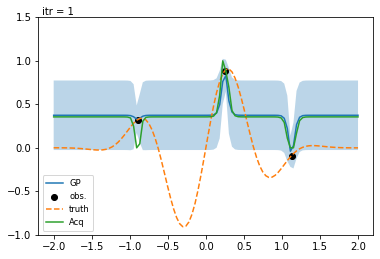

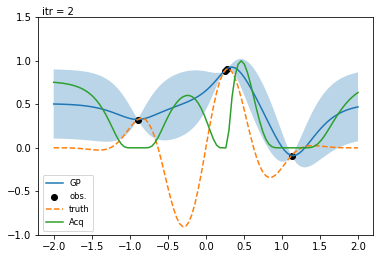

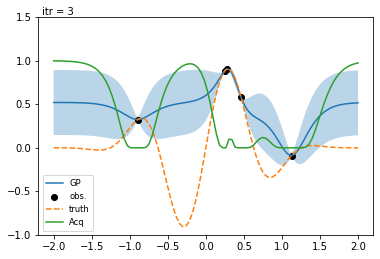

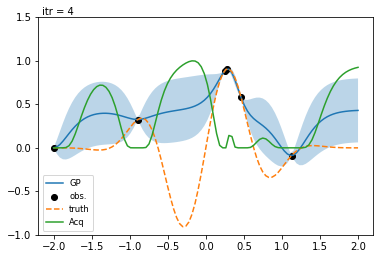

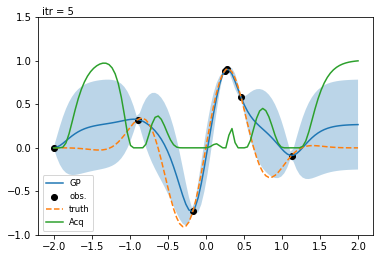

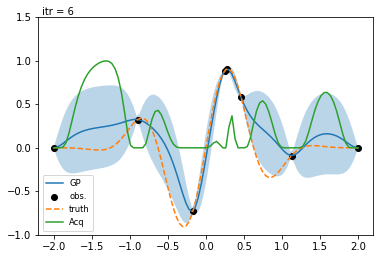

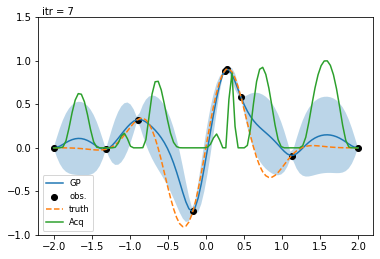

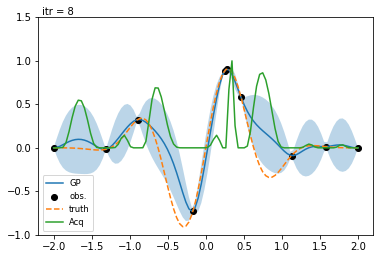

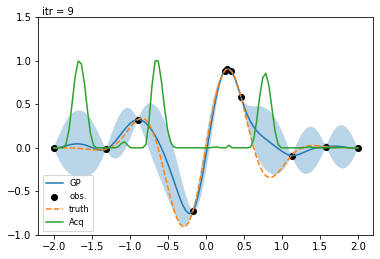

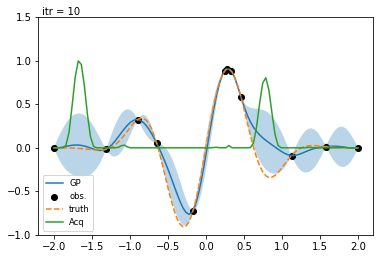

In [5]:
for idx in range(n_eval):
    fig, ax = plt.subplots()
    _animate(idx)